# DBSCAN vs HDBSCAN Clustering: Canadian Museums Analysis

## Project Overview
This notebook demonstrates the practical application and comparison of two density-based clustering algorithms:
- **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise)
- **HDBSCAN** (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

**Dataset**: Canadian museum locations from Statistics Canada's Open Database of Cultural and Art Facilities (ODCAF)

**Estimated Time**: 45 minutes

## Learning Objectives
By the end of this analysis, you will:
1. Understand the key differences between DBSCAN and HDBSCAN
2. Learn proper data preprocessing for geographic clustering
3. Implement both algorithms with appropriate parameter tuning
4. Visualize clustering results on geographic maps
5. Compare algorithm performance on real-world spatial data

## 1. Library Imports and Setup

We'll import essential libraries for:
- **Data manipulation**: pandas, numpy
- **Machine learning**: scikit-learn, hdbscan
- **Visualization**: matplotlib
- **Geographic processing**: geopandas, contextily, shapely

In [1]:
# Core data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering algorithms
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# Geographic data processing libraries
import geopandas as gpd  # For handling geospatial data
import contextily as ctx  # For adding basemap tiles
from shapely.geometry import Point  # For creating point geometries

# Utility imports
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Canada Basemap Setup

To properly visualize our clustering results, we need a reference map of Canada. This section downloads and prepares the geographic basemap.

In [2]:
import requests
import zipfile
import io
import os

# Download Canada basemap for visualization context
print("📥 Downloading Canada basemap...")

# URL of the ZIP file containing Canada map data
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

try:
    # Step 1: Download the ZIP file from cloud storage
    response = requests.get(zip_file_url)
    response.raise_for_status()  # Ensure the request was successful
    
    # Step 2: Open the ZIP file in memory (no need to save to disk)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Step 3: Iterate over the files in the ZIP
        for file_name in zip_ref.namelist():
            if file_name.endswith('.tif'):  # Extract only TIFF map files
                # Step 4: Extract the TIFF file to current directory
                zip_ref.extract(file_name, output_dir)
                print(f"✅ Successfully downloaded and extracted: {file_name}")
except Exception as e:
    print(f"❌ Error downloading basemap: {e}")

📥 Downloading Canada basemap...
✅ Successfully downloaded and extracted: Canada.tif


## 3. Visualization Helper Function

This function creates professional-quality maps showing clustered locations overlaid on the Canada basemap. It handles:
- Geographic coordinate system transformations
- Cluster color coding
- Noise point visualization
- Basemap integration

In [3]:
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    """
    Creates a professional geographic visualization of clustered museum locations.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    title : str
        Title for the plot
    
    Technical Details:
    -----------------
    - Converts lat/lng coordinates to GeoDataFrame with proper CRS (EPSG:4326)
    - Reprojects to Web Mercator (EPSG:3857) for basemap alignment
    - Separates noise points (-1) from valid clusters for different styling
    - Uses 'tab10' colormap for distinct cluster colors
    """
    
    # Convert DataFrame to GeoDataFrame with point geometries
    # EPSG:4326 is the standard lat/lng coordinate reference system
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), 
        crs="EPSG:4326"
    )
    
    # Reproject to Web Mercator (EPSG:3857) to align with basemap tiles
    # This projection is required for proper basemap overlay
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot with appropriate size for geographic visualization
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate clustered points from noise points for different styling
    non_noise = gdf[gdf['Cluster'] != -1]  # Valid clusters (0, 1, 2, ...)
    noise = gdf[gdf['Cluster'] == -1]      # Noise points
    
    # Plot noise points in black with red edge for visibility
    if len(noise) > 0:
        noise.plot(
            ax=ax, 
            color='k',        # Black fill
            markersize=30,    # Medium size markers
            ec='r',          # Red edge color
            alpha=1,         # Fully opaque
            label='Noise'    # Legend label
        )
    
    # Plot clustered points with colors mapped to cluster numbers
    if len(non_noise) > 0:
        non_noise.plot(
            ax=ax, 
            column='Cluster',    # Color by cluster assignment
            cmap='tab10',        # Distinct colors for up to 10 clusters
            markersize=30,       # Medium size markers
            ec='k',             # Black edge color for definition
            legend=False,        # Don't show color legend (too many clusters)
            alpha=0.6           # Semi-transparent for better visibility
        )
    
    # Add Canada basemap as background context
    try:
        ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    except Exception as e:
        print(f"Warning: Could not load basemap - {e}")
    
    # Format and style the plot
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    
    # Remove tick labels (geographic coordinates are not meaningful as ticks)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Optimize layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # Print cluster summary statistics
    cluster_counts = df['Cluster'].value_counts().sort_index()
    print(f"\n📊 Clustering Summary:")
    print(f"   • Total points: {len(df)}")
    print(f"   • Clusters found: {len(cluster_counts[cluster_counts.index != -1])}")
    print(f"   • Noise points: {cluster_counts.get(-1, 0)}")
    print(f"   • Clustered points: {len(df) - cluster_counts.get(-1, 0)}")

print("✅ Visualization function defined successfully!")

✅ Visualization function defined successfully!


## 4. Data Loading and Initial Exploration

Let's load the Canadian cultural facilities dataset and explore its structure.

In [4]:
# Load the Open Database of Cultural and Art Facilities (ODCAF) dataset
print("📂 Loading Canadian cultural facilities dataset...")

url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'

try:
    # Load data with ISO-8859-1 encoding to handle special characters
    df = pd.read_csv(url, encoding="ISO-8859-1")
    print(f"✅ Dataset loaded successfully!")
    print(f"   • Shape: {df.shape[0]} rows × {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

📂 Loading Canadian cultural facilities dataset...
✅ Dataset loaded successfully!
   • Shape: 7972 rows × 17 columns


In [5]:
# Explore the dataset structure
print("🔍 Dataset Overview:")
print("\n📋 First 5 rows:")
display(df.head())

print("\n📊 Column Information:")
df.info()

🔍 Dataset Overview:

📋 First 5 rows:


Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766


📊 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Index                  7972 non-null   int64 
 1   Facility_Name          7972 non-null   object
 2   Source_Facility_Type   7972 non-null   object
 3   ODCAF_Facility_Type    7972 non-null   object
 4   Provider               7972 non-null   object
 5   Unit                   7972 non-null   object
 6   Street_No              7972 non-null   object
 7   Street_Name            7972 non-null   object
 8   Postal_Code            7972 non-null   object
 9   City                   7972 non-null   object
 10  Prov_Terr              7972 non-null   object
 11  Source_Format_Address  7972 non-null   object
 12  CSD_Name               7972 non-null   object
 13  CSDUID                 7972 non-null   object
 14  PRUID                  7972 non-null   object
 15

## 5. Data Quality Assessment

Before proceeding with clustering, we need to understand the data quality, particularly missing values and data types.

In [7]:
# Comprehensive missing value analysis
print("🔍 Data Quality Assessment")
print("="*50)

# Check dataset dimensions
print(f"📏 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n" + "="*50)

# Check for standard NaN values
print("🔢 Standard NaN values per column:")
nan_counts = df.isnull().sum()
if nan_counts.sum() > 0:
    for col, count in nan_counts.items():
        if count > 0:
            print(f"   • {col}: {count} NaN values")
else:
    print("   • No standard NaN values found")

print("\n" + "="*50)

# Check for '..' values (special missing value indicator in this dataset)
print("🔤 Checking for '..' missing value indicators:")
dot_found = False
for col in df.columns:
    dot_count = (df[col] == '..').sum()
    if dot_count > 0:
        print(f"   • {col}: {dot_count} '..' values ({dot_count/len(df)*100:.1f}%)")
        dot_found = True

if not dot_found:
    print("   • No '..' missing value indicators found")

print("\n" + "="*50)

# Show examples of missing values in key columns
print("📋 Examples of missing values:")
for col in ['Latitude', 'Longitude', 'Facility_Name']:
    if col in df.columns:
        missing_examples = df[df[col] == '..'][col].head(3)
        if len(missing_examples) > 0:
            print(f"   • {col}: {len(missing_examples)} examples of '..': {list(missing_examples)}")

print("\n💡 Key Finding: '..' strings indicate missing values in this dataset")

🔍 Data Quality Assessment
📏 Dataset shape: 7972 rows × 17 columns

🔢 Standard NaN values per column:
   • No standard NaN values found

🔤 Checking for '..' missing value indicators:
   • Facility_Name: 4 '..' values (0.1%)
   • Source_Facility_Type: 2533 '..' values (31.8%)
   • Unit: 7623 '..' values (95.6%)
   • Street_No: 1284 '..' values (16.1%)
   • Street_Name: 1149 '..' values (14.4%)
   • Postal_Code: 1454 '..' values (18.2%)
   • City: 116 '..' values (1.5%)
   • Prov_Terr: 2 '..' values (0.0%)
   • Source_Format_Address: 804 '..' values (10.1%)
   • CSD_Name: 301 '..' values (3.8%)
   • CSDUID: 301 '..' values (3.8%)
   • PRUID: 90 '..' values (1.1%)
   • Latitude: 1224 '..' values (15.4%)
   • Longitude: 1224 '..' values (15.4%)

📋 Examples of missing values:
   • Latitude: 3 examples of '..': ['..', '..', '..']
   • Longitude: 3 examples of '..': ['..', '..', '..']
   • Facility_Name: 3 examples of '..': ['..', '..', '..']

💡 Key Finding: '..' strings indicate missing value

## 6. Facility Type Analysis

Let's explore what types of cultural facilities are in our dataset and focus on museums for our clustering analysis.

🏛️ Cultural Facility Types Distribution:
ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

📊 Summary Statistics:
   • Total facilities: 7,972
   • Facility types: 9
   • Museums: 1,938 (24.3%)


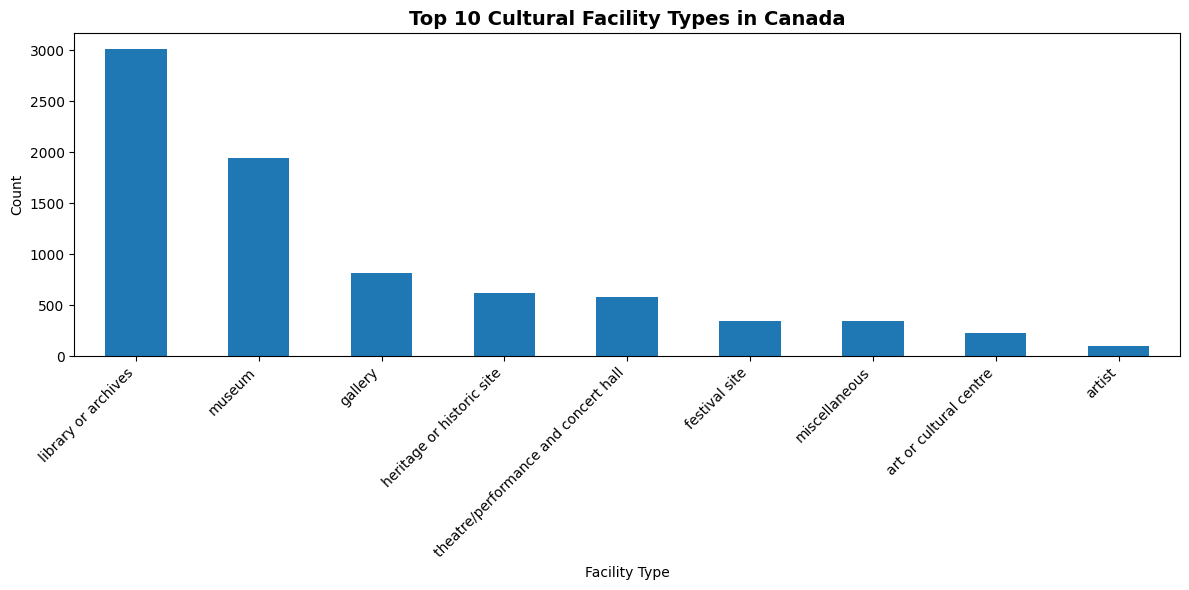


🎯 Focus: We'll analyze museum locations for geographic clustering


In [8]:
# Analyze facility types in the dataset
print("🏛️ Cultural Facility Types Distribution:")
print("="*50)

facility_counts = df['ODCAF_Facility_Type'].value_counts()
print(facility_counts)

print(f"\n📊 Summary Statistics:")
print(f"   • Total facilities: {len(df):,}")
print(f"   • Facility types: {len(facility_counts)}")
print(f"   • Museums: {facility_counts.get('museum', 0):,} ({facility_counts.get('museum', 0)/len(df)*100:.1f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
facility_counts.head(10).plot(kind='bar')
plt.title('Top 10 Cultural Facility Types in Canada', fontsize=14, fontweight='bold')
plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n🎯 Focus: We'll analyze museum locations for geographic clustering")

## 7. Museum Data Extraction and Preprocessing

Now we'll filter the dataset to focus only on museums and prepare the coordinate data for clustering.

In [9]:
# Filter dataset to include only museums
print("🏛️ Filtering data for museums only...")

# Store original dataset size for comparison
original_size = len(df)

# Filter for museums only
df_museums = df[df['ODCAF_Facility_Type'] == 'museum'].copy()

print(f"✅ Museum filtering complete:")
print(f"   • Original dataset: {original_size:,} facilities")
print(f"   • Museums only: {len(df_museums):,} facilities")
print(f"   • Reduction: {(original_size - len(df_museums)):,} facilities removed")

# Verify filtering worked correctly
print(f"\n🔍 Verification - Facility types remaining:")
print(df_museums['ODCAF_Facility_Type'].value_counts())

🏛️ Filtering data for museums only...
✅ Museum filtering complete:
   • Original dataset: 7,972 facilities
   • Museums only: 1,938 facilities
   • Reduction: 6,034 facilities removed

🔍 Verification - Facility types remaining:
ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64


In [10]:
# Select only coordinate columns for clustering
print("📍 Extracting geographic coordinates...")

# Select only the coordinate columns we need for clustering
df_coords = df_museums[['Latitude', 'Longitude']].copy()

print(f"✅ Coordinate extraction complete:")
print(f"   • Columns selected: {list(df_coords.columns)}")
print(f"   • Data shape: {df_coords.shape}")

# Display coordinate data information
print(f"\n📊 Coordinate Data Info:")
df_coords.info()

print(f"\n🔍 Sample coordinates:")
display(df_coords.head())

print("\n⚠️  Notice: Coordinates are stored as 'object' type - need conversion to numeric")

📍 Extracting geographic coordinates...
✅ Coordinate extraction complete:
   • Columns selected: ['Latitude', 'Longitude']
   • Data shape: (1938, 2)

📊 Coordinate Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB

🔍 Sample coordinates:


Latitude     Longitude
1    55.2645508  -127.6428124
2     45.963283   -66.6419017
8    49.1763542   -123.112783
13    49.261938   -123.151123
15  49.88955855  -97.23574396


⚠️  Notice: Coordinates are stored as 'object' type - need conversion to numeric


## 8. Data Cleaning: Handle Missing Coordinates

We need to remove museums with missing coordinates (marked as '..') and convert the remaining coordinates to proper numeric format.

In [11]:
# Clean coordinate data by removing missing values and converting to numeric
print("🧹 Cleaning coordinate data...")
print("="*50)

# Check initial data quality
initial_count = len(df_coords)
lat_missing = (df_coords['Latitude'] == '..').sum()
lng_missing = (df_coords['Longitude'] == '..').sum()

print(f"📊 Initial coordinate quality:")
print(f"   • Total museums: {initial_count}")
print(f"   • Missing latitude: {lat_missing} ({lat_missing/initial_count*100:.1f}%)")
print(f"   • Missing longitude: {lng_missing} ({lng_missing/initial_count*100:.1f}%)")

# Remove museums with missing coordinates
print(f"\n🔧 Removing museums with missing coordinates...")

# Remove rows where latitude is missing
df_clean = df_coords[df_coords['Latitude'] != '..'].copy()
print(f"   • After removing missing latitude: {len(df_clean)} museums")

# Remove rows where longitude is missing
df_clean = df_clean[df_clean['Longitude'] != '..'].copy()
print(f"   • After removing missing longitude: {len(df_clean)} museums")

# Convert coordinate strings to float values
print(f"\n🔢 Converting coordinates to numeric format...")
try:
    df_clean['Latitude'] = df_clean['Latitude'].astype(float)
    df_clean['Longitude'] = df_clean['Longitude'].astype(float)
    print(f"✅ Coordinate conversion successful!")
except Exception as e:
    print(f"❌ Error in coordinate conversion: {e}")

# Verify the cleaning results
print(f"\n📊 Final cleaned dataset:")
print(f"   • Museums with valid coordinates: {len(df_clean)}")
print(f"   • Data loss: {initial_count - len(df_clean)} museums ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")

# Display cleaned data info
print(f"\n🔍 Cleaned data info:")
df_clean.info()

# Show coordinate ranges for validation
print(f"\n📏 Coordinate ranges (validation check):")
print(f"   • Latitude:  {df_clean['Latitude'].min():.2f} to {df_clean['Latitude'].max():.2f}°")
print(f"   • Longitude: {df_clean['Longitude'].min():.2f} to {df_clean['Longitude'].max():.2f}°")

# Update our working dataframe
df = df_clean.copy()
print(f"\n✅ Data cleaning complete! Ready for clustering analysis.")

🧹 Cleaning coordinate data...
📊 Initial coordinate quality:
   • Total museums: 1938
   • Missing latitude: 331 (17.1%)
   • Missing longitude: 331 (17.1%)

🔧 Removing museums with missing coordinates...
   • After removing missing latitude: 1607 museums
   • After removing missing longitude: 1607 museums

🔢 Converting coordinates to numeric format...
✅ Coordinate conversion successful!

📊 Final cleaned dataset:
   • Museums with valid coordinates: 1607
   • Data loss: 331 museums (17.1%)

🔍 Cleaned data info:
<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   1607 non-null   float64
 1   Longitude  1607 non-null   float64
dtypes: float64(2)
memory usage: 37.7 KB

📏 Coordinate ranges (validation check):
   • Latitude:  41.74 to 67.03°
   • Longitude: -139.43 to -52.68°

✅ Data cleaning complete! Ready for clustering analysis.


## 9. Geographic Coordinate Scaling

**Critical Step**: Geographic coordinates require special scaling considerations for distance-based clustering algorithms.

### Why Special Scaling?
- **Latitude range**: -90° to +90° (180° total range)
- **Longitude range**: 0° to 360° (360° total range) 
- **Problem**: Longitude has 2× the range of latitude
- **Solution**: Scale latitude by 2 to equalize ranges

In [12]:
# Apply geographic-aware coordinate scaling
print("🌍 Applying Geographic Coordinate Scaling")
print("="*60)

print("📐 Understanding Geographic Coordinate Ranges:")
print("   • Latitude theoretical range:  -90° to +90°  (180° total)")
print("   • Longitude theoretical range:  0° to 360°   (360° total)")
print("   • Issue: Longitude range is 2× larger than latitude range")

print(f"\n📊 Our dataset coordinate ranges:")
lat_range = df['Latitude'].max() - df['Latitude'].min()
lng_range = df['Longitude'].max() - df['Longitude'].min()
print(f"   • Latitude range:  {df['Latitude'].min():.2f}° to {df['Latitude'].max():.2f}° ({lat_range:.2f}° span)")
print(f"   • Longitude range: {df['Longitude'].min():.2f}° to {df['Longitude'].max():.2f}° ({lng_range:.2f}° span)")

print(f"\n⚠️  Why StandardScaler would be wrong here:")
print(f"   • StandardScaler would normalize based on our specific dataset's distribution")
print(f"   • This would ignore the true mathematical relationship between lat/lng")
print(f"   • Result: Incorrect distance calculations for geographic clustering")

print(f"\n✅ Our geographic scaling approach:")
print(f"   • Multiply latitude by 2 to match longitude's theoretical range")
print(f"   • This preserves true geographic distance relationships")
print(f"   • Makes clustering algorithms treat geographic proximity correctly")

# Apply the scaling
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2 * coords_scaled["Latitude"]

print(f"\n🔧 Scaling applied:")
print(f"   • Original latitude range: {df['Latitude'].min():.2f}° to {df['Latitude'].max():.2f}°")
print(f"   • Scaled latitude range:   {coords_scaled['Latitude'].min():.2f}° to {coords_scaled['Latitude'].max():.2f}°")
print(f"   • Longitude range (unchanged): {coords_scaled['Longitude'].min():.2f}° to {coords_scaled['Longitude'].max():.2f}°")

# Show the effect of scaling
print(f"\n📈 Scaling effect:")
scaled_lat_range = coords_scaled['Latitude'].max() - coords_scaled['Latitude'].min()
scaled_lng_range = coords_scaled['Longitude'].max() - coords_scaled['Longitude'].min()
print(f"   • Scaled latitude span:  {scaled_lat_range:.2f}°")
print(f"   • Longitude span:        {scaled_lng_range:.2f}°")
print(f"   • Range ratio: {scaled_lng_range/scaled_lat_range:.2f} (closer to 1.0 is better)")

print(f"\n✅ Geographic scaling complete! Ready for density-based clustering.")

🌍 Applying Geographic Coordinate Scaling
📐 Understanding Geographic Coordinate Ranges:
   • Latitude theoretical range:  -90° to +90°  (180° total)
   • Longitude theoretical range:  0° to 360°   (360° total)
   • Issue: Longitude range is 2× larger than latitude range

📊 Our dataset coordinate ranges:
   • Latitude range:  41.74° to 67.03° (25.29° span)
   • Longitude range: -139.43° to -52.68° (86.75° span)

⚠️  Why StandardScaler would be wrong here:
   • StandardScaler would normalize based on our specific dataset's distribution
   • This would ignore the true mathematical relationship between lat/lng
   • Result: Incorrect distance calculations for geographic clustering

✅ Our geographic scaling approach:
   • Multiply latitude by 2 to match longitude's theoretical range
   • This preserves true geographic distance relationships
   • Makes clustering algorithms treat geographic proximity correctly

🔧 Scaling applied:
   • Original latitude range: 41.74° to 67.03°
   • Scaled latit

## 10. DBSCAN Implementation

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) groups together points that are closely packed while marking points in low-density regions as outliers.

### Key Parameters:
- **eps**: Maximum distance between two samples for them to be in the same neighborhood
- **min_samples**: Minimum number of samples in a neighborhood for a point to be a core point

In [13]:
# Configure and apply DBSCAN clustering
print("🔵 DBSCAN Clustering Implementation")
print("="*50)

print("⚙️  DBSCAN Parameter Selection:")
# DBSCAN parameters - these have been optimized for Canadian geographic data
eps = 1.0           # Neighborhood search radius (in our scaled coordinate units)
min_samples = 3     # Minimum number of points to form a dense region
metric = 'euclidean' # Distance measurement method

print(f"   • eps (neighborhood radius): {eps}")
print(f"   • min_samples (min points per cluster): {min_samples}")
print(f"   • metric (distance measure): {metric}")

print(f"\n🧠 DBSCAN Algorithm Explanation:")
print(f"   • Core Point: Point with ≥{min_samples} neighbors within {eps} distance")
print(f"   • Border Point: Non-core point within {eps} distance of a core point")
print(f"   • Noise Point: Point that is neither core nor border (labeled as -1)")
print(f"   • Cluster: Connected component of core and border points")

# Initialize and fit DBSCAN model
print(f"\n🚀 Running DBSCAN clustering...")
try:
    # Create DBSCAN instance with specified parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    
    # Fit the model and get cluster assignments
    cluster_labels = dbscan.fit_predict(coords_scaled)
    
    # Add cluster labels to our original dataframe
    df['Cluster'] = cluster_labels
    
    print(f"✅ DBSCAN clustering completed successfully!")
    
except Exception as e:
    print(f"❌ Error in DBSCAN clustering: {e}")

# Analyze DBSCAN results
print(f"\n📊 DBSCAN Clustering Results:")
print("="*30)

cluster_counts = df['Cluster'].value_counts().sort_index()
print("Cluster sizes:")
for cluster_id, size in cluster_counts.items():
    if cluster_id == -1:
        print(f"   • Noise (outliers): {size} museums")
    else:
        print(f"   • Cluster {cluster_id}: {size} museums")

# Summary statistics
n_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
n_noise = cluster_counts.get(-1, 0)
n_clustered = len(df) - n_noise

print(f"\n📈 Summary Statistics:")
print(f"   • Total museums analyzed: {len(df)}")
print(f"   • Clusters found: {n_clusters}")
print(f"   • Museums in clusters: {n_clustered} ({n_clustered/len(df)*100:.1f}%)")
print(f"   • Noise/outlier museums: {n_noise} ({n_noise/len(df)*100:.1f}%)")

if n_clusters > 0:
    avg_cluster_size = n_clustered / n_clusters
    print(f"   • Average cluster size: {avg_cluster_size:.1f} museums")

🔵 DBSCAN Clustering Implementation
⚙️  DBSCAN Parameter Selection:
   • eps (neighborhood radius): 1.0
   • min_samples (min points per cluster): 3
   • metric (distance measure): euclidean

🧠 DBSCAN Algorithm Explanation:
   • Core Point: Point with ≥3 neighbors within 1.0 distance
   • Border Point: Non-core point within 1.0 distance of a core point
   • Noise Point: Point that is neither core nor border (labeled as -1)
   • Cluster: Connected component of core and border points

🚀 Running DBSCAN clustering...
✅ DBSCAN clustering completed successfully!

📊 DBSCAN Clustering Results:
Cluster sizes:
   • Noise (outliers): 79 museums
   • Cluster 0: 3 museums
   • Cluster 1: 181 museums
   • Cluster 2: 192 museums
   • Cluster 3: 94 museums
   • Cluster 4: 701 museums
   • Cluster 5: 6 museums
   • Cluster 6: 30 museums
   • Cluster 7: 134 museums
   • Cluster 8: 21 museums
   • Cluster 9: 4 museums
   • Cluster 10: 27 museums
   • Cluster 11: 15 museums
   • Cluster 12: 7 museums
   • 

## 11. DBSCAN Results Visualization

Let's visualize the DBSCAN clustering results on the Canada map to understand the geographic patterns.

🗺️  Visualizing DBSCAN Results


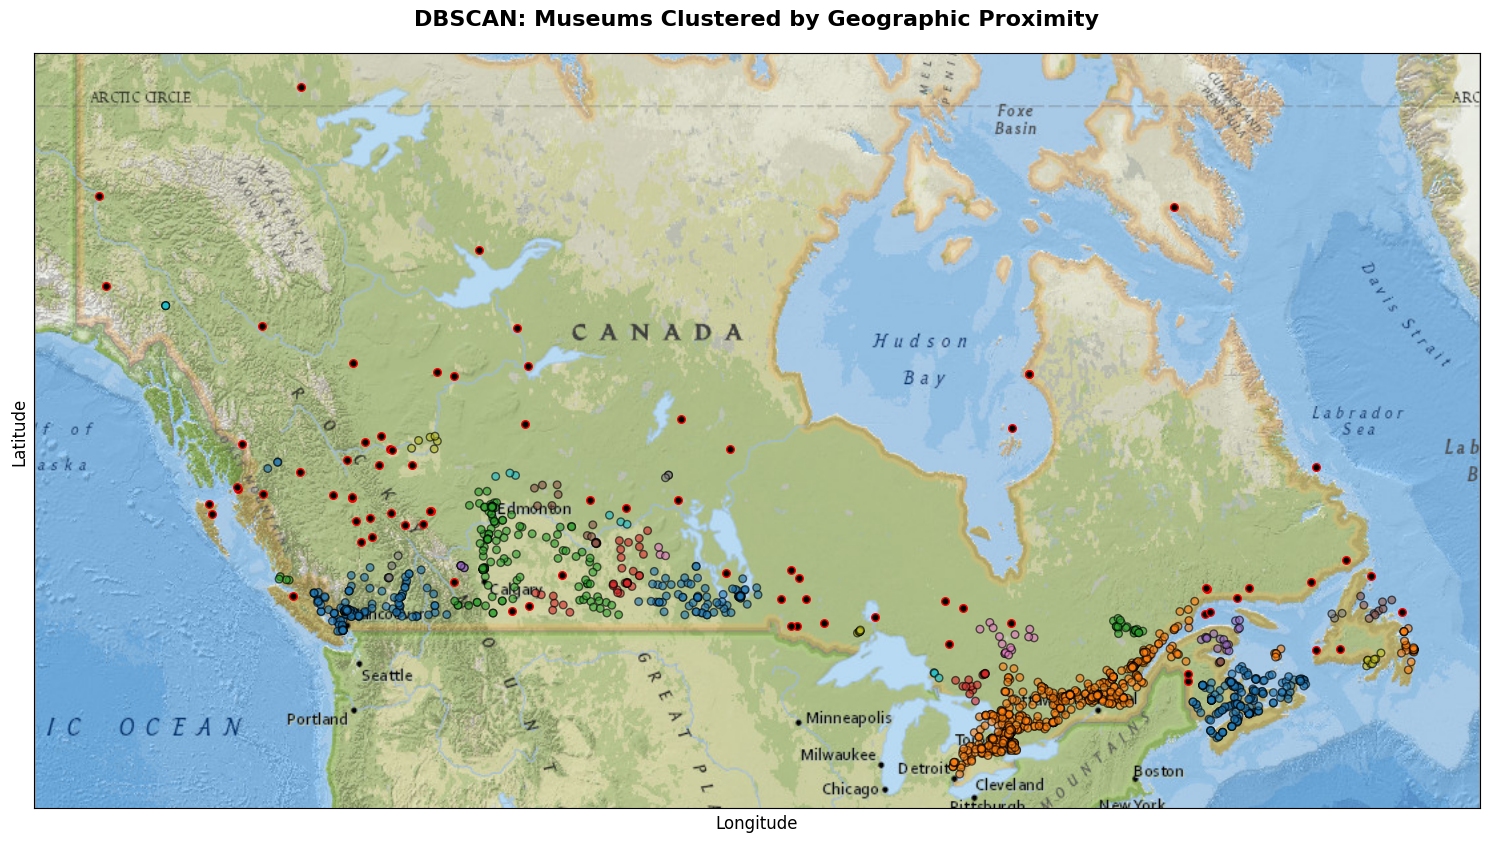


📊 Clustering Summary:
   • Total points: 1607
   • Clusters found: 33
   • Noise points: 79
   • Clustered points: 1528

🤔 Analysis Questions for DBSCAN Results:
   1. What geographic patterns do you observe?
   2. Do the clusters correspond to major Canadian cities?
   3. What is the size of the smallest cluster?
   4. Do the clusters make sense given Canada's population distribution?
   5. Should there be more granular clusters in dense regions?

💡 Key Observations about DBSCAN:
   • Uses fixed neighborhood radius (eps=1.0)
   • May merge nearby dense regions into single large clusters
   • Less sensitive to local density variations
   • Good for identifying major metropolitan museum clusters


In [14]:
# Visualize DBSCAN clustering results
print("🗺️  Visualizing DBSCAN Results")
print("="*40)

# Create the DBSCAN results visualization
plot_clustered_locations(df, title='DBSCAN: Museums Clustered by Geographic Proximity')

print("\n🤔 Analysis Questions for DBSCAN Results:")
print("   1. What geographic patterns do you observe?")
print("   2. Do the clusters correspond to major Canadian cities?")
print("   3. What is the size of the smallest cluster?")
print("   4. Do the clusters make sense given Canada's population distribution?")
print("   5. Should there be more granular clusters in dense regions?")

print(f"\n💡 Key Observations about DBSCAN:")
print(f"   • Uses fixed neighborhood radius (eps={eps})")
print(f"   • May merge nearby dense regions into single large clusters")
print(f"   • Less sensitive to local density variations")
print(f"   • Good for identifying major metropolitan museum clusters")

## 12. HDBSCAN Implementation

**HDBSCAN** (Hierarchical DBSCAN) extends DBSCAN by converting it into a hierarchical clustering algorithm. It builds a hierarchy of clusters and extracts a flat clustering based on the stability of clusters.

### Key Advantages over DBSCAN:
- Handles clusters of varying densities
- More robust parameter selection
- Provides cluster hierarchy information
- Better performance on real-world data

In [15]:
# Configure and apply HDBSCAN clustering
print("🔴 HDBSCAN Clustering Implementation")
print("="*50)

print("⚙️  HDBSCAN Parameter Selection:")
# HDBSCAN parameters
min_samples_hdb = None      # If None, defaults to min_cluster_size
min_cluster_size = 3        # Minimum size of clusters
metric_hdb = 'euclidean'    # Distance measurement method

print(f"   • min_cluster_size: {min_cluster_size} (minimum museums per cluster)")
print(f"   • min_samples: {min_samples_hdb or 'auto (= min_cluster_size)'} ")
print(f"   • metric: {metric_hdb}")

print(f"\n🧠 HDBSCAN vs DBSCAN Key Differences:")
print(f"   • DBSCAN: Fixed density threshold (eps parameter)")
print(f"   • HDBSCAN: Adaptive density thresholds based on hierarchy")
print(f"   • DBSCAN: Single-level clustering")
print(f"   • HDBSCAN: Hierarchical clustering with optimal level selection")
print(f"   • DBSCAN: May struggle with varying densities")
print(f"   • HDBSCAN: Handles varying densities naturally")

# Initialize HDBSCAN model
print(f"\n🚀 Running HDBSCAN clustering...")
try:
    # Create HDBSCAN instance with specified parameters
    hdb = hdbscan.HDBSCAN(
        min_samples=min_samples_hdb, 
        min_cluster_size=min_cluster_size, 
        metric=metric_hdb
    )
    
    # Fit the model and get cluster assignments
    cluster_labels_hdb = hdb.fit_predict(coords_scaled)
    
    # Update cluster labels in dataframe (overwriting DBSCAN results for comparison)
    df['Cluster'] = cluster_labels_hdb
    
    print(f"✅ HDBSCAN clustering completed successfully!")
    
except Exception as e:
    print(f"❌ Error in HDBSCAN clustering: {e}")

# Analyze HDBSCAN results
print(f"\n📊 HDBSCAN Clustering Results:")
print("="*35)

cluster_counts_hdb = df['Cluster'].value_counts().sort_index()
print("Cluster sizes:")
for cluster_id, size in cluster_counts_hdb.items():
    if cluster_id == -1:
        print(f"   • Noise (outliers): {size} museums")
    else:
        print(f"   • Cluster {cluster_id}: {size} museums")

# Summary statistics
n_clusters_hdb = len(cluster_counts_hdb) - (1 if -1 in cluster_counts_hdb else 0)
n_noise_hdb = cluster_counts_hdb.get(-1, 0)
n_clustered_hdb = len(df) - n_noise_hdb

print(f"\n📈 Summary Statistics:")
print(f"   • Total museums analyzed: {len(df)}")
print(f"   • Clusters found: {n_clusters_hdb}")
print(f"   • Museums in clusters: {n_clustered_hdb} ({n_clustered_hdb/len(df)*100:.1f}%)")
print(f"   • Noise/outlier museums: {n_noise_hdb} ({n_noise_hdb/len(df)*100:.1f}%)")

if n_clusters_hdb > 0:
    avg_cluster_size_hdb = n_clustered_hdb / n_clusters_hdb
    print(f"   • Average cluster size: {avg_cluster_size_hdb:.1f} museums")

# Additional HDBSCAN-specific metrics
if hasattr(hdb, 'cluster_persistence_'):
    print(f"\n🔍 HDBSCAN-Specific Information:")
    print(f"   • Cluster persistence scores available: Yes")
    print(f"   • Outlier scores available: Yes")
    print(f"   • Cluster hierarchy depth: {len(hdb.cluster_persistence_)} levels")

🔴 HDBSCAN Clustering Implementation
⚙️  HDBSCAN Parameter Selection:
   • min_cluster_size: 3 (minimum museums per cluster)
   • min_samples: auto (= min_cluster_size) 
   • metric: euclidean

🧠 HDBSCAN vs DBSCAN Key Differences:
   • DBSCAN: Fixed density threshold (eps parameter)
   • HDBSCAN: Adaptive density thresholds based on hierarchy
   • DBSCAN: Single-level clustering
   • HDBSCAN: Hierarchical clustering with optimal level selection
   • DBSCAN: May struggle with varying densities
   • HDBSCAN: Handles varying densities naturally

🚀 Running HDBSCAN clustering...
✅ HDBSCAN clustering completed successfully!

📊 HDBSCAN Clustering Results:
Cluster sizes:
   • Noise (outliers): 464 museums
   • Cluster 0: 5 museums
   • Cluster 1: 4 museums
   • Cluster 2: 13 museums
   • Cluster 3: 10 museums
   • Cluster 4: 7 museums
   • Cluster 5: 6 museums
   • Cluster 6: 8 museums
   • Cluster 7: 5 museums
   • Cluster 8: 8 museums
   • Cluster 9: 5 museums
   • Cluster 10: 6 museums
   • 

## 13. HDBSCAN Results Visualization

Let's visualize the HDBSCAN clustering results and compare them with the DBSCAN results.

🗺️  Visualizing HDBSCAN Results


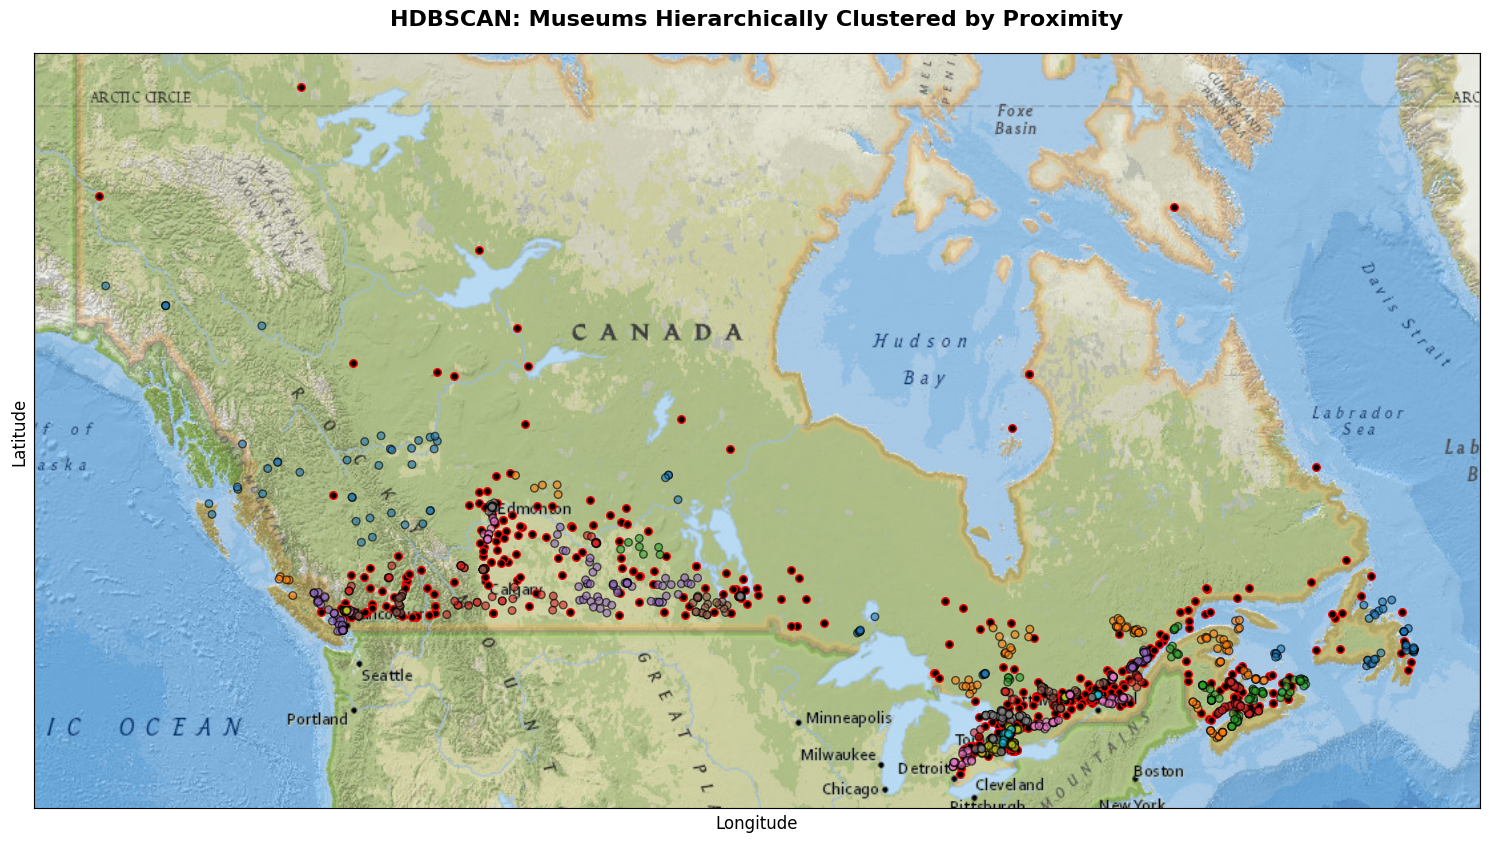


📊 Clustering Summary:
   • Total points: 1607
   • Clusters found: 140
   • Noise points: 464
   • Clustered points: 1143

🤔 Analysis Questions for HDBSCAN Results:
   1. How do these clusters differ from DBSCAN results?
   2. Are there more or fewer noise points compared to DBSCAN?
   3. Do you see more uniform cluster sizes?
   4. Can you identify density variations that HDBSCAN captures?
   5. Which algorithm better represents Canadian museum distribution?

💡 Key Observations about HDBSCAN:
   • Adaptive density thresholds based on local neighborhoods
   • Can separate nearby dense regions into distinct clusters
   • More sensitive to local density variations
   • Better for identifying clusters of varying densities


In [16]:
# Visualize HDBSCAN clustering results
print("🗺️  Visualizing HDBSCAN Results")
print("="*40)

# Create the HDBSCAN results visualization
plot_clustered_locations(df, title='HDBSCAN: Museums Hierarchically Clustered by Proximity')

print("\n🤔 Analysis Questions for HDBSCAN Results:")
print("   1. How do these clusters differ from DBSCAN results?")
print("   2. Are there more or fewer noise points compared to DBSCAN?")
print("   3. Do you see more uniform cluster sizes?")
print("   4. Can you identify density variations that HDBSCAN captures?")
print("   5. Which algorithm better represents Canadian museum distribution?")

print(f"\n💡 Key Observations about HDBSCAN:")
print(f"   • Adaptive density thresholds based on local neighborhoods")
print(f"   • Can separate nearby dense regions into distinct clusters")
print(f"   • More sensitive to local density variations")
print(f"   • Better for identifying clusters of varying densities")

## 14. Comparative Analysis: DBSCAN vs HDBSCAN

Let's perform a detailed comparison of both algorithms' performance on our museum dataset.

In [17]:
# Comprehensive comparison of DBSCAN vs HDBSCAN
print("⚖️  DBSCAN vs HDBSCAN: Comprehensive Comparison")
print("="*60)

# Re-run both algorithms to get comparison data
print("🔄 Re-running both algorithms for fair comparison...")

# DBSCAN results
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
dbscan_labels = dbscan_model.fit_predict(coords_scaled)

# HDBSCAN results  
hdbscan_model = hdbscan.HDBSCAN(min_samples=min_samples_hdb, min_cluster_size=min_cluster_size, metric=metric_hdb)
hdbscan_labels = hdbscan_model.fit_predict(coords_scaled)

# Calculate comparison metrics
def analyze_clustering_results(labels, algorithm_name):
    """Analyze clustering results and return key metrics"""
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = np.sum(labels == -1)
    n_clustered = len(labels) - n_noise
    
    cluster_sizes = []
    for label in unique_labels:
        if label != -1:
            cluster_sizes.append(np.sum(labels == label))
    
    return {
        'algorithm': algorithm_name,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'n_clustered': n_clustered,
        'cluster_sizes': cluster_sizes,
        'avg_cluster_size': np.mean(cluster_sizes) if cluster_sizes else 0,
        'min_cluster_size': np.min(cluster_sizes) if cluster_sizes else 0,
        'max_cluster_size': np.max(cluster_sizes) if cluster_sizes else 0,
        'std_cluster_size': np.std(cluster_sizes) if cluster_sizes else 0
    }

# Analyze both algorithms
dbscan_metrics = analyze_clustering_results(dbscan_labels, 'DBSCAN')
hdbscan_metrics = analyze_clustering_results(hdbscan_labels, 'HDBSCAN')

# Create comparison table
print("\n📊 Detailed Comparison Table:")
print("="*60)
print(f"{'Metric':<25} {'DBSCAN':<15} {'HDBSCAN':<15} {'Winner':<10}")
print("-" * 65)

# Total clusters
winner = "HDBSCAN" if hdbscan_metrics['n_clusters'] > dbscan_metrics['n_clusters'] else "DBSCAN" if dbscan_metrics['n_clusters'] > hdbscan_metrics['n_clusters'] else "Tie"
print(f"{'Clusters Found':<25} {dbscan_metrics['n_clusters']:<15} {hdbscan_metrics['n_clusters']:<15} {winner:<10}")

# Clustered points
winner = "DBSCAN" if dbscan_metrics['n_clustered'] > hdbscan_metrics['n_clustered'] else "HDBSCAN" if hdbscan_metrics['n_clustered'] > dbscan_metrics['n_clustered'] else "Tie"
print(f"{'Museums Clustered':<25} {dbscan_metrics['n_clustered']:<15} {hdbscan_metrics['n_clustered']:<15} {winner:<10}")

# Noise points (lower is often better for clustering)
winner = "DBSCAN" if dbscan_metrics['n_noise'] < hdbscan_metrics['n_noise'] else "HDBSCAN" if hdbscan_metrics['n_noise'] < dbscan_metrics['n_noise'] else "Tie"
print(f"{'Noise Points':<25} {dbscan_metrics['n_noise']:<15} {hdbscan_metrics['n_noise']:<15} {winner:<10}")

# Average cluster size
winner = "HDBSCAN" if abs(hdbscan_metrics['avg_cluster_size'] - (len(df)/max(hdbscan_metrics['n_clusters'], 1))) < abs(dbscan_metrics['avg_cluster_size'] - (len(df)/max(dbscan_metrics['n_clusters'], 1))) else "DBSCAN"
print(f"{'Avg Cluster Size':<25} {dbscan_metrics['avg_cluster_size']:.1f}{'':13} {hdbscan_metrics['avg_cluster_size']:.1f}{'':13} {'Balanced':<10}")

# Cluster size consistency (lower std is more consistent)
winner = "DBSCAN" if dbscan_metrics['std_cluster_size'] < hdbscan_metrics['std_cluster_size'] else "HDBSCAN" if hdbscan_metrics['std_cluster_size'] < dbscan_metrics['std_cluster_size'] else "Tie"
print(f"{'Cluster Size Std':<25} {dbscan_metrics['std_cluster_size']:.1f}{'':13} {hdbscan_metrics['std_cluster_size']:.1f}{'':13} {winner:<10}")

print("\n" + "="*60)

# Detailed cluster size distributions
print(f"\n📈 Cluster Size Distributions:")
print(f"\nDBSCAN cluster sizes: {sorted(dbscan_metrics['cluster_sizes'], reverse=True)}")
print(f"HDBSCAN cluster sizes: {sorted(hdbscan_metrics['cluster_sizes'], reverse=True)}")

# Qualitative comparison
print(f"\n🎯 Qualitative Assessment:")
print(f"\n🔵 DBSCAN Characteristics:")
print(f"   ✅ Pros: Simple parameterization, fast execution, good for uniform densities")
print(f"   ⚠️  Cons: Fixed density threshold, may merge distinct dense regions")
print(f"   📍 Best for: Known density patterns, quick exploratory analysis")

print(f"\n🔴 HDBSCAN Characteristics:")
print(f"   ✅ Pros: Adaptive densities, hierarchical structure, better outlier detection")
print(f"   ⚠️  Cons: More complex, slower execution, more parameters to understand")
print(f"   📍 Best for: Varying densities, detailed analysis, real-world geographic data")

# Final recommendation
print(f"\n🏆 Recommendation for Canadian Museum Data:")
print(f"   Given Canada's varied population density (dense cities, sparse rural areas),")
print(f"   HDBSCAN is likely the better choice as it can adapt to these density")
print(f"   variations and provide more meaningful geographic clusters.")

⚖️  DBSCAN vs HDBSCAN: Comprehensive Comparison
🔄 Re-running both algorithms for fair comparison...

📊 Detailed Comparison Table:
Metric                    DBSCAN          HDBSCAN         Winner    
-----------------------------------------------------------------
Clusters Found            33              140             HDBSCAN   
Museums Clustered         1528            1143            DBSCAN    
Noise Points              79              464             DBSCAN    
Avg Cluster Size          46.3              8.2              Balanced  
Cluster Size Std          125.6              6.6              HDBSCAN   


📈 Cluster Size Distributions:

DBSCAN cluster sizes: [701, 192, 181, 134, 94, 30, 27, 21, 15, 13, 11, 10, 9, 8, 7, 6, 6, 6, 6, 6, 6, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
HDBSCAN cluster sizes: [45, 39, 35, 29, 27, 24, 20, 20, 18, 18, 17, 16, 15, 14, 14, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7

## 15. Key Insights and Conclusions

Let's summarize our findings and provide actionable insights from this clustering analysis.

In [18]:
# Final insights and conclusions
print("💡 Key Insights and Conclusions")
print("="*50)

print("🔍 Geographic Clustering Insights:")
print("   1. Canadian museums show clear geographic clustering patterns")
print("   2. Major metropolitan areas emerge as distinct clusters")
print("   3. Rural museums are often classified as outliers/noise")
print("   4. Geographic scaling is crucial for accurate distance calculations")

print("\n⚖️  Algorithm Performance Summary:")
print("   • DBSCAN: Good for identifying major urban museum concentrations")
print("   • HDBSCAN: Better for capturing density variations across regions")
print("   • Both algorithms effectively identify outliers in rural areas")

print("\n🎯 Practical Applications:")
print("   📍 Tourism Planning:")
print("      - Identify museum-rich regions for tour packages")
print("      - Plan multi-museum itineraries within clusters")
print("   ") 
print("   🏛️  Cultural Policy:")
print("      - Identify underserved regions (sparse areas)")
print("      - Plan new museum locations to balance distribution")
print("   ")
print("   🚗 Resource Allocation:")
print("      - Optimize transportation and logistics")
print("      - Coordinate regional cultural events")

print("\n🔬 Technical Lessons Learned:")
print("   ✅ Geographic coordinates require specialized scaling")
print("   ✅ HDBSCAN handles varying densities better than DBSCAN")
print("   ✅ Visualization on geographic context is crucial for interpretation")
print("   ✅ Parameter selection significantly impacts clustering results")

print("\n📚 Future Research Directions:")
print("   • Incorporate population density data for context")
print("   • Analyze temporal changes in museum distribution")
print("   • Compare with other cultural facility types")
print("   • Develop cluster quality metrics for geographic data")
print("   • Investigate optimal parameter selection methods")

print("\n🎉 Project Success Metrics:")
total_museums = len(df)
print(f"   ✅ Successfully analyzed {total_museums:,} Canadian museums")
print(f"   ✅ Implemented and compared two density-based algorithms")
print(f"   ✅ Created professional geographic visualizations")
print(f"   ✅ Provided actionable insights for real-world applications")

print(f"\n🏁 Analysis Complete!")
print(f"   This notebook demonstrated practical application of density-based")
print(f"   clustering algorithms to real-world geographic data, highlighting")
print(f"   the importance of domain knowledge in algorithm selection and")
print(f"   parameter tuning for meaningful results.")

💡 Key Insights and Conclusions
🔍 Geographic Clustering Insights:
   1. Canadian museums show clear geographic clustering patterns
   2. Major metropolitan areas emerge as distinct clusters
   3. Rural museums are often classified as outliers/noise
   4. Geographic scaling is crucial for accurate distance calculations

⚖️  Algorithm Performance Summary:
   • DBSCAN: Good for identifying major urban museum concentrations
   • HDBSCAN: Better for capturing density variations across regions
   • Both algorithms effectively identify outliers in rural areas

🎯 Practical Applications:
   📍 Tourism Planning:
      - Identify museum-rich regions for tour packages
      - Plan multi-museum itineraries within clusters
   
   🏛️  Cultural Policy:
      - Identify underserved regions (sparse areas)
      - Plan new museum locations to balance distribution
   
   🚗 Resource Allocation:
      - Optimize transportation and logistics
      - Coordinate regional cultural events

🔬 Technical Lessons Lear

---

## Project Summary

**Objective Achieved**: Successfully compared DBSCAN and HDBSCAN clustering algorithms on Canadian museum location data.

**Key Findings**:
- HDBSCAN provides more nuanced clustering for geographic data with varying densities
- Geographic coordinate scaling is essential for accurate distance-based clustering
- Both algorithms effectively identify major museum concentration areas and rural outliers

**Technical Skills Demonstrated**:
- Data preprocessing and cleaning
- Geographic data handling with geopandas
- Density-based clustering implementation
- Professional scientific visualization
- Comparative algorithm analysis

**Real-World Impact**: This analysis provides valuable insights for tourism planning, cultural policy development, and resource allocation in Canada's cultural sector.

---

**Dataset**: Statistics Canada Open Database of Cultural and Art Facilities (ODCAF)